In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\I822363\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\I822363\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
remove=('headers', 'footers', 'quotes')
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True,
                                      remove=(),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True,
                                     remove=(),
                                     categories=categories)

num_test = len(newsgroups_test.target)
int_num_test = int(num_test/2)
test_data, test_labels = newsgroups_test.data[int_num_test:], newsgroups_test.target[int_num_test:]
dev_data, dev_labels = newsgroups_test.data[:int_num_test], newsgroups_test.target[:int_num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
from time import time

print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = newsgroups_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

train_data_size_mb = size_mb(train_data)
dev_data_size_mb = size_mb(dev_data)

print("%d documents - %0.3fMB (training set)" % (
    len(train_data), train_data_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(dev_data), dev_data_size_mb))
print("%d categories" % len(categories))
print()


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()

vectorizer = CountVectorizer( 
#                              max_df=0.5
                              )
X_train = vectorizer.fit_transform(train_data)
y_train = train_labels
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, train_data_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()


print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_dev = vectorizer.transform(dev_data)
y_dev = dev_labels
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, dev_data_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_dev.shape)
print()




data loaded
2034 documents - 3.980MB (training set)
676 documents - 1.560MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.649462s at 6.127MB/s
n_samples: 2034, n_features: 34118

Extracting features from the test data using the same vectorizer
done in 0.207148s at 7.531MB/s
n_samples: 676, n_features: 34118



KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') 
best parameters: {'n_neighbors': 5, 'weights': 'distance'}
best score: 0.753 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 
best parameters: {'alpha': 0.01}
best score: 0.959 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
best parameters: {'C': 10.0}
best score: 0.955 



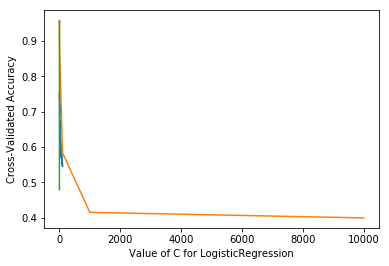

In [4]:
def gridSearch(
                clf, parameters, plot_x_axis_text, x_range,
                X_train = X_train,
                y_train = y_train,
                X_dev   = X_dev,
                y_dev   = y_dev
               ):
    grid = GridSearchCV(clf, parameters, cv=10)
    grid.fit(X_train, y_train)
    print(clf, "\nbest parameters:", grid.best_params_)
    print("best score: %.3f \n" % grid.best_score_)
    grid.score(X_dev, y_dev)
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

    plt.plot(x_range, grid_mean_scores)
    plt.xlabel(plot_x_axis_text)
    plt.ylabel('Cross-Validated Accuracy')
    return grid
    

knn = KNeighborsClassifier(algorithm = 'brute')
parameters = [{'weights': [
    'uniform', 'distance'], 'n_neighbors': [
        5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}]
k_range = [5,5,10,10,20,20,30,30,40,40,50,50,60,60,70,70,80,80,90,90,100,100]
grid_kNN = gridSearch(knn, parameters, "Value of K for KNN", k_range)

MNB = MultinomialNB()
parameter_MNB = {'alpha': 10. ** np.arange(-5,5)}
alpha_range = 10. ** np.arange(-5,5)
grid_MNB = gridSearch(MNB, parameter_MNB, "Value of alpha for MNB", alpha_range)

LR = LogisticRegression()
parameter_LR = {'C': 10. ** np.arange(-5,2)}
C_range = 10. ** np.arange(-5,2)
grid_LR = gridSearch(
    LR, parameter_LR, "Value of C for LogisticRegression", C_range)

In [5]:
import sys
from sklearn.utils.extmath import density
import logging


# mapping from integer feature name to original token string
feature_names = vectorizer.get_feature_names()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf, 
              ipts_print_report='', ipts_print_cm='', ipts_print_top10='Y',
              X_train = X_train,
              y_train = y_train,
              X_dev   = X_dev,
              y_dev   = y_dev
              ):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_dev)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_dev, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if ipts_print_top10 == 'Y' and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if ipts_print_report:
        print("classification report:")
        print(metrics.classification_report(y_dev, pred,
                                            target_names=target_names))

    if ipts_print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_dev, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

results = []
for clf, name in (
        (KNeighborsClassifier(**grid_kNN.best_params_), "kNN"),
        (MultinomialNB(**grid_MNB.best_params_), "MultinomialNB"),
        (LogisticRegression(**grid_LR.best_params_), 'LogisticReg')
        ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, ipts_print_report='Y'))
print('Results = \n')
print(results)


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')
train time: 0.003s
test time:  0.157s
accuracy:   0.605
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.62      0.61      0.61       165
     comp.graphics       0.60      0.77      0.67       185
         sci.space       0.83      0.50      0.63       199
talk.religion.misc       0.43      0.52      0.47       127

       avg / total       0.64      0.61      0.61       676


MultinomialNB
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.009s
test time:  0.002s
accuracy:   0.904
dimensionality: 34118
density: 1.000000
top 10 keywords per class:
alt.ath

4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?



In [6]:
def p4(
                X_train = X_train,
                y_train = y_train,
                X_dev   = X_dev,
                y_dev   = y_dev
):
    print(X_train.shape)
    results = []
    twenty = []
    clf, name = (
        LogisticRegression(), 
        'LogisticReg with L2 regularization')

    print('=' * 80)
    print(name)
    results.append(benchmark(
                             clf, ipts_print_top10='N',
                             X_train = X_train,
                             y_train = y_train,
                             X_dev = X_dev,
                             y_dev = y_dev )
                  )
    
    twenty_rows = []
    for i, label in enumerate(target_names):
        top5 = np.argsort(clf.coef_[i])[-5:]
        top5_features = feature_names[top5]
        twenty_rows.extend([j for j in top5_features])
        twenty.extend(j for j in top5)
    #    print(trim("%19s: %s " % (
    #    label, " ".join(map(
    #    str, clf.coef_[i,top5].round(decimals=3))))))
    #    print(top5_features)
    
    print('shape: ',clf.coef_.shape)
    return pd.DataFrame(
             data    = clf.coef_[:, twenty].round(decimals=3).T, 
             index   = twenty_rows,  
             columns = target_names  )

label_coef = p4()
label_coef.style.highlight_max(axis=1)

(2034, 34118)
LogisticReg with L2 regularization
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
train time: 1.305s
test time:  0.002s
accuracy:   0.855
dimensionality: 34118
density: 1.000000


shape:  (4, 34118)


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
okcforum,0.606,-0.222,-0.176,-0.271
bible,0.625,-0.338,-0.255,-0.09
atheism,0.669,-0.248,-0.232,-0.384
keith,0.855,-0.378,-0.421,-0.475
atheists,0.875,-0.279,-0.263,-0.588
files,-0.268,0.564,-0.347,-0.277
file,-0.046,0.613,-0.393,-0.392
42,-0.142,0.62,-0.212,-0.268
image,-0.3,0.756,-0.415,-0.249
graphics,-0.48,1.18,-0.694,-0.607


In [7]:
cv = CountVectorizer(ngram_range=(2,2))

X_train_bigram = cv.fit_transform(train_data)
y_train_bigram = train_labels

X_dev_bigram = cv.transform(test_data)
y_dev_bigram = test_labels

# mapping from integer feature name to original token string
feature_names = cv.get_feature_names()

if feature_names:
    feature_names = np.asarray(feature_names)


# Do grid search for best C value (l2 regu') for the new 
# bigrams
#parameter_LR = {'C': 10. ** np.arange(-5,2)}
#C_range = 10. ** np.arange(-5,2)

#LR = LogisticRegression()
#grid_LR = gridSearch(
#    LR, 
#    parameter_LR, 
#    "Value of C for LogisticRegression", C_range,
#    X_train_bigram, y_train_bigram, X_dev_bigram, y_dev_bigram)

In [8]:
# Perform logistic regression classification
label_coef = p4(X_train_bigram, y_train_bigram, X_dev_bigram, y_dev_bigram)
label_coef.style.highlight_max(axis=1)

(2034, 245460)
LogisticReg with L2 regularization
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
train time: 4.577s
test time:  0.004s
accuracy:   0.848
dimensionality: 245460
density: 1.000000


shape:  (4, 245460)


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
bu edu,0.421,-0.139,-0.138,-0.258
osrhe edu,0.497,-0.242,-0.138,-0.155
okcforum osrhe,0.497,-0.242,-0.138,-0.155
edu keith,0.602,-0.336,-0.298,-0.228
caltech edu,0.632,-0.305,-0.18,-0.359
university of,-0.395,0.403,-0.269,-0.319
graphics library,-0.151,0.417,-0.257,-0.151
comp graphics,-0.171,0.455,-0.254,-0.19
in advance,-0.309,0.471,-0.264,-0.361
looking for,-0.508,0.681,-0.284,-0.546
